In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [14]:
# import libs
import glob, pylab, pandas as pd
import pydicom, numpy as np
import random
import json
import time
import copy
import pydicom
import torchvision
import sys
import math

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler
from torch.autograd import Variable
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

from sklearn.model_selection import train_test_split
# from torchvision import datasets, transforms
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader
# from torch.optim import lr_scheduler
from pathlib import Path
from tqdm import tqdm     


from fastai.transforms import tfms_from_model,transforms_side_on, CropType
from fastai.model import resnet34
from fastai.conv_learner import *
from fastai.dataset import *


In [3]:
TEST = True

In [5]:
PATH = Path('./data/rsna')
# read training lables
train_bb_df = pd.read_csv(PATH/'stage_1_train_labels.csv')
train_bb_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
train_bb_df['duplicate'] = train_bb_df.duplicated(['patientId'], keep=False)
# see data
train_bb_df[train_bb_df['duplicate']].head()


,patientId,x,y,width,height,Target,duplicate
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,True
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,True
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,True
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,True
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,True


In [7]:
detailed_df = pd.read_csv(PATH/'stage_1_detailed_class_info.csv')
# detailed_df.head()
# merge two df
class_df = train_bb_df.merge(detailed_df, on="patientId")
# len(class_df) # -> 35875 it is way more than original df.
# class_df[class_df.duplicated()]
class_df.drop_duplicates(inplace=True)
class_df.head() # len is 28989. 
csv_df = class_df.filter(['patientId', 'Target'], )


In [8]:
img_dir = PATH/'stage_1_train_images'
sample = list(img_dir.iterdir())
if TEST:
    sample = sample[:1000]
train, test = train_test_split(sample)
batch_size=32
sz=224
tloc = PATH/'sample'/str(sz)
def scale_to(x, ratio, targ): 
    '''Calculate dimension of an image during scaling with aspect ratio'''
    return max(math.floor(x*ratio), targ)

def read_image_resize(tsize=sz, tloc=tloc):
    tloc.mkdir(parents=True, exist_ok=True)
    for loc in tqdm(sample):
        img_arr = pydicom.read_file(loc.as_posix()).pixel_array
        img_arr = np.stack([img_arr] * 3, axis=2)
        img_arr = img_arr/img_arr.max()
        img_arr = (255*img_arr).clip(0, 255).astype(np.uint8)
        img_arr = Image.fromarray(img_arr)#.convert('RGB') # model expects 3 channel image
        r,c = img_arr.size
        ratio = tsize/min(r,c)
        sz = (scale_to(r, ratio, tsize), scale_to(c, ratio, tsize))
        img_arr = img_arr.resize(sz, Image.LINEAR)
        filepath = tloc / loc.name
#         np.save(filepath, img_arr, )
        img_arr.save((tloc/loc.stem).as_posix()+'.png')


try:
    if len(list(tloc.iterdir())) < 1000:
        read_image_resize()
except FileNotFoundError:
    read_image_resize()

100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


In [123]:
def show_img(im, figsize=None, ax=None):
#     im = np.transpose(im, (1,2,0))
    if not ax: 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
  o.set_path_effects([patheffects.Stroke(
      linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def get_category(i):
    return class_df.iloc[i].Target

In [11]:
IMG_SIZE = 1024
def resized (patients, resize):
    if not resize:
        return (patients.x, patients.y, patients.width, patients.height)
    else:
        scale = IMG_SIZE/resize
        return (patients.x/scale, patients.y/scale, patients.width/scale, patients.height/scale)

def get_bb(im_loc, only_one=True, resize=None):
    patientId = im_loc.name.split('.dcm')[0]
    patients = class_df[class_df['patientId'] == patientId]

    patients.iloc[np.argsort(patients.width * patients.height).values]
    if only_one:
        patients = patients.iloc[-1:].iloc[0]
        return resized(patients, resize)
    else:
        return [resized(patients.iloc[i], resize )for i in range(len(patients))]

In [73]:
csv_df = class_df.filter(['patientId', 'Target'], )
csv_df['patientId'] += '.png'
if TEST:
    sample_file = [i.name for i in tloc.iterdir()]
    csv_df = csv_df[csv_df.patientId.isin(sample_file)]
CSV = PATH/'cat.csv'
print (len(csv_df))
csv_df.to_csv(CSV,index=False)
f_model = resnet34
sz=224
bs=64

1137


In [74]:
try: 
    del md
except Exception: pass
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, 'sample/224', CSV, tfms=tfms, bs=bs)

In [75]:
x,y=next(iter(md.val_dl))


(
 ( 0 , 0 ,.,.) = 
  -2.0665 -2.0494 -2.0494  ...  -2.0323 -2.0323 -2.0323
  -2.0494 -2.0494 -2.0494  ...  -2.0323 -2.0323 -2.0323
  -2.0494 -2.0494 -2.0494  ...  -2.0152 -2.0152 -2.0323
            ...             ⋱             ...          
   1.2899  1.4954  1.4954  ...  -1.4500 -1.8782 -1.9467
   1.3070  1.5125  1.4954  ...  -1.5014 -1.9124 -1.9467
   1.0844  1.2728  1.2557  ...  -1.5699 -1.9295 -1.9638
 
 ( 0 , 1 ,.,.) = 
  -1.9832 -1.9657 -1.9657  ...  -1.9482 -1.9482 -1.9482
  -1.9657 -1.9657 -1.9657  ...  -1.9482 -1.9482 -1.9482
  -1.9657 -1.9657 -1.9657  ...  -1.9307 -1.9307 -1.9482
            ...             ⋱             ...          
   1.4482  1.6583  1.6583  ...  -1.3529 -1.7906 -1.8606
   1.4657  1.6758  1.6583  ...  -1.4055 -1.8256 -1.8606
   1.2381  1.4307  1.4132  ...  -1.4755 -1.8431 -1.8782
 
 ( 0 , 2 ,.,.) = 
  -1.7522 -1.7347 -1.7347  ...  -1.7173 -1.7173 -1.7173
  -1.7347 -1.7347 -1.7347  ...  -1.7173 -1.7173 -1.7173
  -1.7347 -1.7347 -1.7347  ...  -1.6999 -1.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


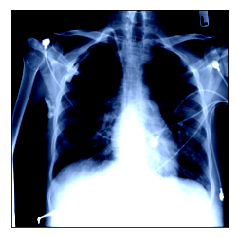

In [76]:
show_img(x[0]);

In [77]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [78]:
lrf=learn.lr_find(1e-2,100)

  7%|▋         | 1/15 [00:10<02:22, 10.17s/it, loss=0.885]

/home/nikhil/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 87%|████████▋ | 13/15 [00:13<00:02,  1.05s/it, loss=234] 

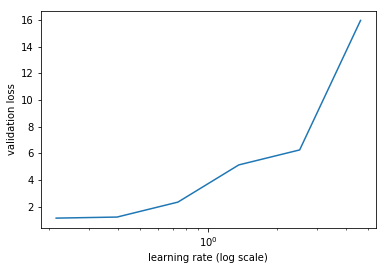

In [82]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [83]:
lr = .01
learn.fit(lr, 1, cycle_len=1)

  7%|▋         | 1/15 [00:01<00:16,  1.21s/it, loss=1.04]

/home/nikhil/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch      trn_loss   val_loss   accuracy                  
    0      0.814079   0.514372   0.770925  


[array([0.51437]), 0.7709251122327628]

  0%|          | 0/15 [00:00<?, ?it/s]

/home/nikhil/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


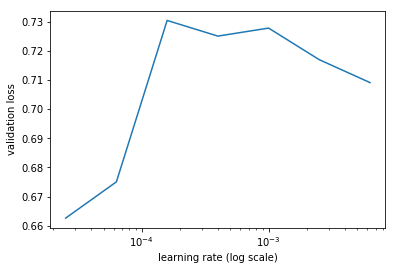

In [84]:
lrs = np.array([lr/1000,lr/100,lr])
learn.freeze_to(-2)
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [85]:
learn.fit(lrs/5, 1, cycle_len=1)

  0%|          | 0/15 [00:00<?, ?it/s]

/home/nikhil/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch      trn_loss   val_loss   accuracy                  
    0      0.537076   0.542231   0.788546  


[array([0.54223]), 0.7885462573446366]

In [86]:
learn.unfreeze()
learn.fit(lrs/5, 1, cycle_len=2)

  0%|          | 0/15 [00:00<?, ?it/s]

/home/nikhil/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch      trn_loss   val_loss   accuracy                  
    0      0.51526    0.641362   0.748899  
    1      0.45052    0.566414   0.762115                  


[array([0.56641]), 0.7621145387578115]

NOt much improvement in accuracy.

In [87]:
learn.save('reg4')
learn.load('reg4')

/home/nikhil/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


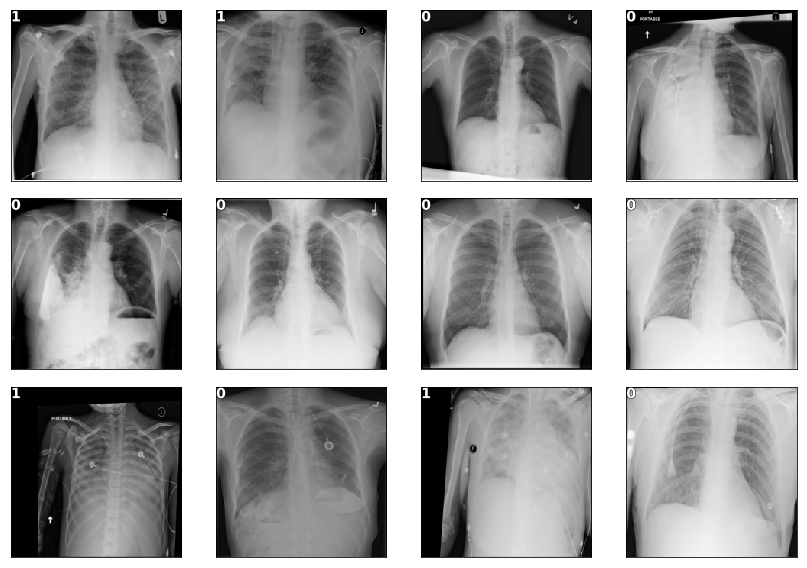

In [126]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = x,to_np(probs)
preds = np.argmax(preds, -1)

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()
    
#     img =np.transpose(x[i],(1,2,0))
#     b = md.classes[preds[i]]
#     ax = show_img(img, ax=ax)
#     draw_rect(ax, b)
    
plt.tight_layout()